In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import logging
import warnings

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn import linear_model as LR
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')
BASE_PATH = os.path.dirname(os.path.abspath('__file__'))

SELF_LEARNER_MODULE_PATH = os.path.abspath(os.path.join(BASE_PATH, os.path.pardir))
SELF_LEARNER_LIB_PATH = os.path.join(SELF_LEARNER_MODULE_PATH, 'selflearner')
os.chdir(SELF_LEARNER_LIB_PATH)
sys.path.insert(0, SELF_LEARNER_MODULE_PATH)

# Paths of dump
import pickle
from zodbpickle import pickle
CLASSES_CNT_DUMP_PATH = os.path.join(SELF_LEARNER_MODULE_PATH, 'classes_count_jla.pkl')
EXP_OUROBOROS_DUMP_PATH = os.path.join(SELF_LEARNER_MODULE_PATH, 'exp_ouroboros_jla.pkl')
EXP_PREVIOUS_PRES_DUMP_PATH = os.path.join(SELF_LEARNER_MODULE_PATH, 'exp_previous_pres_jla.pkl')

from selflearner.multi_day_experiment import MultiDayExperiment
from selflearner.problem_definition import ProblemDefinition, TrainingType
from selflearner.data_load.features_extraction_oulad import Hdf5Creator
import selflearner.selflearner_utils
from selflearner.learning.dead_students_classifier import NeverActiveStudentClassifier

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def lazy_load(file_name, slow_comp_function, args=[], kwargs=None, force_recompute=False):
    """
    Takes care of taking the already pickled experiment so that is not necessary to recompute it.
    """
    if force_recompute is True:
        logging.info("Force recomputation of the models.")
        return slow_comp_function(*args, **kwargs)
    try:
        with open(file_name, "rb") as f:
            logging.debug('Loading from pickle...')
            obj = pickle.load(f)
    except IOError:
        obj = slow_comp_function(*args, **kwargs)
        with open(file_name, "wb") as f:
                pickle.dump(obj, f)
    return obj
    
def compute_experiment(train_mode=TrainingType.SELFLEARNER, max_days=0, module_presentations=None, assessment_name=None,classifiers=None, features=None, sampler=None, max_days_to_predict=None, count_all_days_to_predict=False, min_days=0):
    # Init and run the experiment
    dailyExpPrevPres = MultiDayExperiment(max_days, 
                                        module_presentations=module_presentations,
                                        assessment_name=assessment,
                                        max_days_to_predict=max_days_to_predict,
                                        count_all_days_to_predict=count_all_days_to_predict,
                                        classifiers=classifiers,
                                        features=features,
                                        training_type=train_mode,
                                        sampler=sampler, 
                                        min_days=min_days)
    dailyExpPrevPres.perform_experiment()
    return dailyExpPrevPres

def reload_module_presentations(modules, presentations):
    # ----------------------------------------------------------------------------------------------------------------------
    # Load all the module and presentations 
    # ----------------------------------------------------------------------------------------------------------------------
    manager = Hdf5Creator().get_hdf5_manager()
    df_courses = manager.load_dataframe('courses').reset_index()
    df_courses = df_courses.loc[
        df_courses['code_module'].isin(modules) & df_courses['code_presentation'].isin(presentations)]
    module_presentations = []
    for index, row in df_courses.iterrows():
        module, presentation = row['code_module'], row['code_presentation']
        presentation_train = presentation
        module_presentations.append((module, presentation, presentation_train))

    module_presentations_previous = []
    for index, row in df_courses.iterrows():
        module, presentation = row['code_module'], row['code_presentation']
        presentation_train = selflearner.selflearner_utils.get_prev_pres_same(presentation)
        module_presentations_previous.append((module, presentation, presentation_train))
        
    return module_presentations, module_presentations_previous

In [10]:
modules = ["BBB", "DDD", "EEE", "FFF"]
presentations = ["2014J"]
assessment = "TMA 1"
features = ["demog"]
label_name = "submitted"
sampler = None
max_days = 9
max_days_to_predict = 9

In [11]:
module_presentations, module_presentations_previous = reload_module_presentations(modules, presentations)

In [59]:
def load_or_compute_classes():
    try:
        with open(CLASSES_CNT_DUMP_PATH, "rb") as f:
             expClassNumbers = pickle.load(f)
    except IOError:
        classifiers = [(DummyClassifier(strategy="constant", constant=1), "Base[NS]")
                       ]
        # Init and run the experiment
        expClassNumbers = MultiDayExperiment(max_days, 
                                             max_days_to_predict=max_days_to_predict,
                                             module_presentations=module_presentations, 
                                             count_all_days_to_predict=True,
                                             assessment_name=assessment,
                                             classifiers=classifiers, 
                                             min_days=8)
        expClassNumbers.perform_experiment()
        with open(CLASSES_CNT_DUMP_PATH, "wb") as f:
                pickle.dump(expClassNumbers, f)
    return expClassNumbers

%time expClassNumbers = load_or_compute_classes()

CPU times: user 422 ms, sys: 605 ms, total: 1.03 s
Wall time: 1.73 s


In [60]:
expClassNumbers.get_class_counts_df(relative_counts=False)

,code_module,code_presentation,day,days_to_predict,test_NS,test_S,train_NS,train_S
0,BBB,2014J,8,0,1588,329,2178,25
1,BBB,2014J,8,1,1508,368,2142,61
2,BBB,2014J,8,2,1431,391,2108,95
3,BBB,2014J,8,3,1376,416,2079,124
4,BBB,2014J,8,4,1288,486,2061,142
5,BBB,2014J,8,5,1124,630,2042,161
6,BBB,2014J,8,6,853,862,2003,200
7,BBB,2014J,8,7,515,1146,1953,250
8,BBB,2014J,8,8,317,1278,1892,311
9,BBB,2014J,9,0,1650,332,2225,30


In [61]:
expClassNumbers.get_class_counts_df()

,code_module,code_presentation,day,days_to_predict,train_NS_ratio,test_NS_ratio,train_S_ratio,test_S_ratio
0,BBB,2014J,8,0,0.988652,0.828378,0.011348,0.171622
1,BBB,2014J,8,1,0.972310,0.803838,0.027690,0.196162
2,BBB,2014J,8,2,0.956877,0.785401,0.043123,0.214599
3,BBB,2014J,8,3,0.943713,0.767857,0.056287,0.232143
4,BBB,2014J,8,4,0.935542,0.726043,0.064458,0.273957
5,BBB,2014J,8,5,0.926918,0.640821,0.073082,0.359179
6,BBB,2014J,8,6,0.909215,0.497376,0.090785,0.502624
7,BBB,2014J,8,7,0.886518,0.310054,0.113482,0.689946
8,BBB,2014J,8,8,0.858829,0.198746,0.141171,0.801254
9,BBB,2014J,9,0,0.986696,0.832492,0.013304,0.167508


In [63]:
classifiers = [
         (SVC(kernel="rbf", gamma='auto', C=1, probability=True, class_weight="balanced"), "SVM-W-R"),
#        (SVC(kernel="rbf", gamma='auto', C=1, probability=True), "SVM-R"),
#        (LR.LogisticRegression(C=0.01, penalty='l2'), "LR"),
       (LR.LogisticRegression(C=0.01, penalty='l2', class_weight="balanced"), "LR-W"),
#        (GaussianNB(), "NB"),
#        (RandomForestClassifier(n_estimators=120, max_depth=5, min_samples_split=2, min_samples_leaf=5), "RF"),
         (xgb.XGBClassifier(base_score=0.1, n_estimators=100, max_depth=3, reg_alpha=0.5, reg_lambda=1, learning_rate=0.01 ), "XGB"),
                (NeverActiveStudentClassifier(), "Base[NotAccessed]"),
                (DummyClassifier(strategy="constant", constant=1), "Base[NS]")
              ]

features = [
    "demog"
    ,"vle_statistics"
    , 'vle_statistics_beforestart'
    , "vle_day_activity_type_flags"
    , "vle_day_activity_type"
    , 'vle_day'
    , 'vle_day_flags'
    , 'reg_statistics'
  ]

modules = ["BBB", "DDD", "EEE", "FFF"]
presentations = ["2014J"]
module_presentations, module_presentations_previous = reload_module_presentations(modules, presentations)

kwargs = {'train_mode': TrainingType.SELFLEARNER,
          'max_days': 11,
          'module_presentations':module_presentations_previous,
          'assessment_name':assessment,
          'classifiers':classifiers, 'features':features,
          'max_days_to_predict':max_days_to_predict,
          'count_all_days_to_predict':True
         }

In [64]:
%time dailyExpSelflearner = lazy_load(EXP_OUROBOROS_DUMP_PATH, compute_experiment, kwargs=kwargs)

CPU times: user 4.72 s, sys: 15.5 s, total: 20.2 s
Wall time: 30.3 s


In [71]:
df.head()

,auc,classifier,code_module,code_presentation,day,days_to_predict,fscore,pr_auc,prec,recall
0,0.637312,Base[NotAccessed],BBB,2014J,0,0,0.413284,0.550881,0.736842,0.287179
1,0.500000,Base[NS],BBB,2014J,0,0,0.196672,0.554530,0.109060,1.000000
2,0.780801,SVM-W-R,BBB,2014J,0,0,0.319654,0.442941,0.202462,0.758974
3,0.772873,XGB,BBB,2014J,0,0,0.354883,0.410004,0.242481,0.661538
4,0.787020,LR-W,BBB,2014J,0,0,0.310484,0.455445,0.193225,0.789744


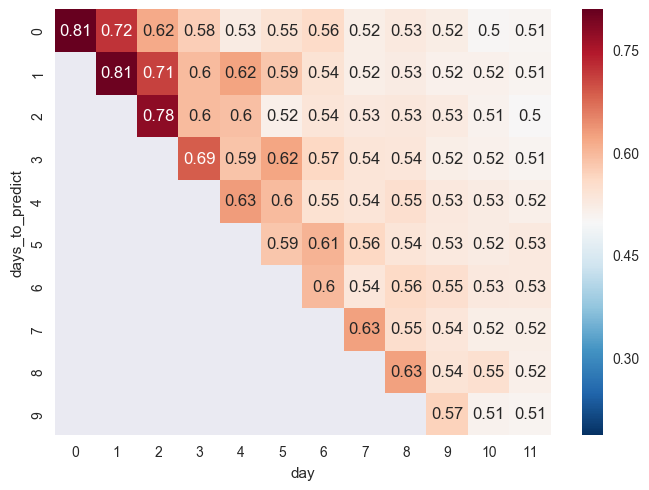

In [119]:
df = dailyExpSelflearner.get_metrics_df()
df_hm = df.fillna(0)
df_hm = df_hm[df_hm.classifier == 'XGB']
df_hm = df_hm.groupby(['days_to_predict','day'])['auc'].median().reset_index()
# df_hm = df_hm[df_hm.code_module == 'DDD']
df_hm = df_hm.pivot( 'days_to_predict','day','auc')
sns.heatmap(df_hm, annot=True, center=0.5)

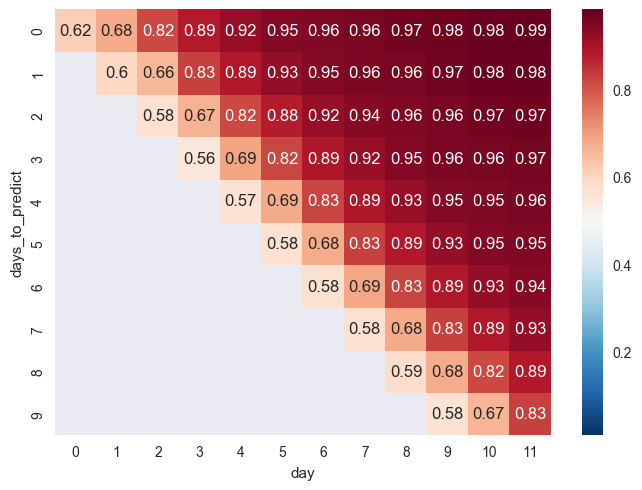

In [118]:
df = dailyExpSelflearner.get_metrics_df()
df_hm = df.fillna(0)
df_hm = df_hm[df_hm.classifier == 'XGB']
df_hm = df_hm.groupby(['days_to_predict','day'])['pr_auc'].median().reset_index()
# df_hm = df_hm[df_hm.code_module == 'DDD']
df_hm = df_hm.pivot( 'days_to_predict','day','pr_auc')
sns.heatmap(df_hm, annot=True, center=0.5)

## Different values of the labeling window 

In [ ]:
# classifiers = [
# #          (SVC(kernel="rbf", gamma='auto', C=1, probability=True, class_weight="balanced"), "SVM-W-R"),
# #        (SVC(kernel="rbf", gamma='auto', C=1, probability=True), "SVM-R"),
# #        (LR.LogisticRegression(C=0.01, penalty='l2'), "LR"),
#        (LR.LogisticRegression(C=0.01, penalty='l2', class_weight="balanced"), "LR-W"),
# #        (GaussianNB(), "NB"),
# #        (RandomForestClassifier(n_estimators=120, max_depth=5, min_samples_split=2, min_samples_leaf=5), "RF"),
# #          (xgb.XGBClassifier(base_score=0.1, n_estimators=100, max_depth=3, reg_alpha=0.5, reg_lambda=1, learning_rate=0.01 ), "XGB"),
#                 (NeverActiveStudentClassifier(), "Base[NotAccessed]"),
#                 (DummyClassifier(strategy="constant", constant=1), "Base[NS]")
#               ]

# features = [
#     "demog"
#     ,"vle_statistics"
#     , 'vle_statistics_beforestart'
#     , "vle_day_activity_type_flags"
#     , "vle_day_activity_type"
#     , 'vle_day'
#     , 'vle_day_flags'
#     , 'reg_statistics'
#   ]

# # modules = ["BBB", "DDD", "EEE", "FFF"]
# modules = ["EEE"]
# presentations = ["2014J"]
# module_presentations, module_presentations_previous = reload_module_presentations(modules, presentations)

# kwargs = {'train_mode': TrainingType.SELFLEARNER,
#           'max_days': 11,
#           'module_presentations':module_presentations_previous,
#           'assessment_name':assessment,
#           'classifiers':classifiers, 
#           'features':features,
#           'max_days_to_predict': None,
#           'count_all_days_to_predict': False,
#           'days_to_label_window': 3,
#           'count_all_days_to_label_window': True
#          }

##  When to intervene and using which k at what time?

In [54]:
# top_k_graph_width = 12
# top_k_graph_height = 7

In [107]:
def fscore(prec, recall):
    return 2 * (prec * recall) / (prec + recall)

def get_time_fscore_k_graph(df_to_consider, model_name):
    p5 = df_to_consider.get_metric_daily_df('top_k_prec', 5)[model_name]
    p10 = df_to_consider.get_metric_daily_df('top_k_prec', 10)[model_name]
    p25 = df_to_consider.get_metric_daily_df('top_k_prec', 25)[model_name]
    p50 = df_to_consider.get_metric_daily_df('top_k_prec', 50)[model_name]
    p75 = df_to_consider.get_metric_daily_df('top_k_prec', 75)[model_name]
    p = df_to_consider.get_metric_daily_df('prec')[model_name]

    r5 = df_to_consider.get_metric_daily_df('top_k_rec', 5)[model_name]
    r10 = df_to_consider.get_metric_daily_df('top_k_rec', 10)[model_name]
    r25 = df_to_consider.get_metric_daily_df('top_k_rec', 25)[model_name]
    r50 = df_to_consider.get_metric_daily_df('top_k_rec', 50)[model_name]
    r75 = df_to_consider.get_metric_daily_df('top_k_rec', 75)[model_name]
    r = df_to_consider.get_metric_daily_df('recall')[model_name]

    df_fscore = pd.DataFrame({
            'f05':fscore(p5,r5),
            'f10':fscore(p10,r10),
            'f25':fscore(p25,r25),
            'f50':fscore(p50,r50),
            'f75':fscore(p75,r75),
            'f':fscore(p,r),
        })
    return df_fscore

CPU times: user 22.7 s, sys: 404 ms, total: 23.1 s
Wall time: 25.5 s


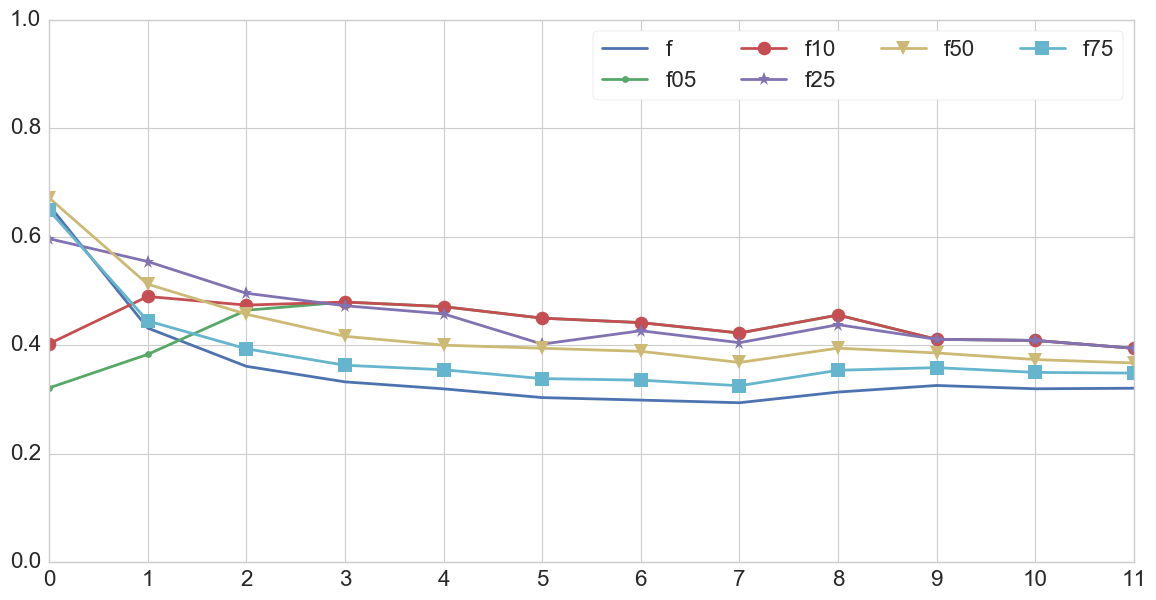

In [108]:
# %time df_fscore = get_time_fscore_k_graph(dailyExpSelflearner, 'XGB')
# plot_df(df_fscore)

CPU times: user 21.3 s, sys: 265 ms, total: 21.6 s
Wall time: 23.6 s


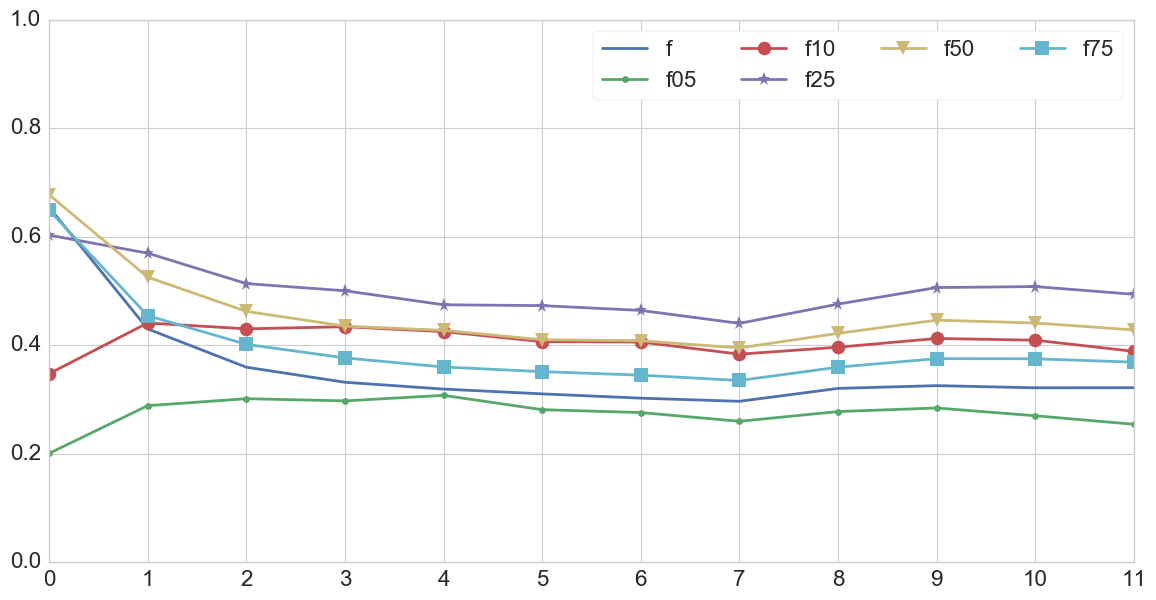

In [110]:
# %time df_fscore = get_time_fscore_k_graph(dailyExpSelflearner, 'RF')
# plot_df(df_fscore)

In [130]:
# df_full_2 = dailyExpPrevPres.get_metrics_k_df()

In [135]:
# df[df.day == 3].sort_values(by='top_k_fscore')

,classifier,code_module,code_presentation,day,k,top_k_rec,top_k_prec,top_k_fscore
2,XGB,BBB,2014J,3,75,0.920000,0.133140,0.232617
2,XGB,FFF,2014J,3,75,1.000000,0.171111,0.292220
3,XGB,BBB,2014J,3,50,0.810000,0.179204,0.293478
4,XGB,BBB,2014J,3,5,0.230000,0.505495,0.316151
0,XGB,BBB,2014J,3,25,0.540000,0.238938,0.331288
4,XGB,FFF,2014J,3,5,0.224026,0.741935,0.344140
2,XGB,DDD,2014J,3,75,0.922780,0.216682,0.350954
1,XGB,BBB,2014J,3,10,0.350000,0.386740,0.367454
4,XGB,EEE,2014J,3,5,0.237864,0.816667,0.368421
2,XGB,EEE,2014J,3,75,0.980583,0.264744,0.416925


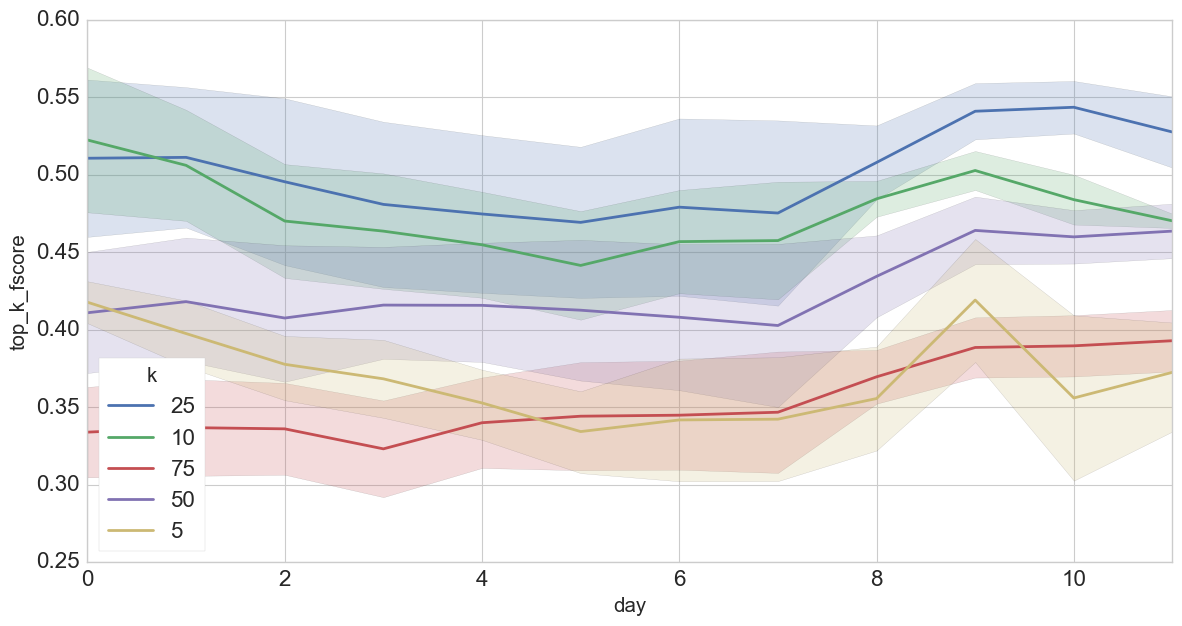

In [132]:
# df = df_full_2
# df['top_k_fscore'] = fscore(df['top_k_prec'], df['top_k_rec'])
# df = df[df.classifier == 'XGB']
# # df[df.day == 0].sort_values(by='top_k_fscore')
# sns.tsplot(time='day', unit='code_module', condition='k', value='top_k_fscore', data=df)

In [94]:
# df_full = dailyExpSelflearner.get_metrics_k_df()
# df = df_full
# import seaborn as sns

In [ ]:
# df = dailyExpSelflearner.get_class_counts_df()
# plot_df(df)

In [136]:
# df = df_full
# df = df[df.classifier == 'XGB']
# df[df.day == 1].sort_values(by='top_k_fscore')

,classifier,code_module,code_presentation,day,k,top_k_rec,top_k_prec,top_k_fscore
4,XGB,BBB,2014J,1,5,0.214286,0.724138,0.330709
4,XGB,EEE,2014J,1,5,0.241935,0.918367,0.382979
4,XGB,DDD,2014J,1,5,0.265625,0.728571,0.389313
2,XGB,DDD,2014J,1,75,0.901042,0.255162,0.397701
1,XGB,BBB,2014J,1,10,0.295918,0.707317,0.417266
4,XGB,FFF,2014J,1,5,0.293706,0.750000,0.422111
2,XGB,FFF,2014J,1,75,0.888112,0.277899,0.423333
3,XGB,DDD,2014J,1,50,0.744792,0.316372,0.444099
2,XGB,BBB,2014J,1,75,0.826531,0.309160,0.450000
1,XGB,DDD,2014J,1,10,0.338542,0.698925,0.456140


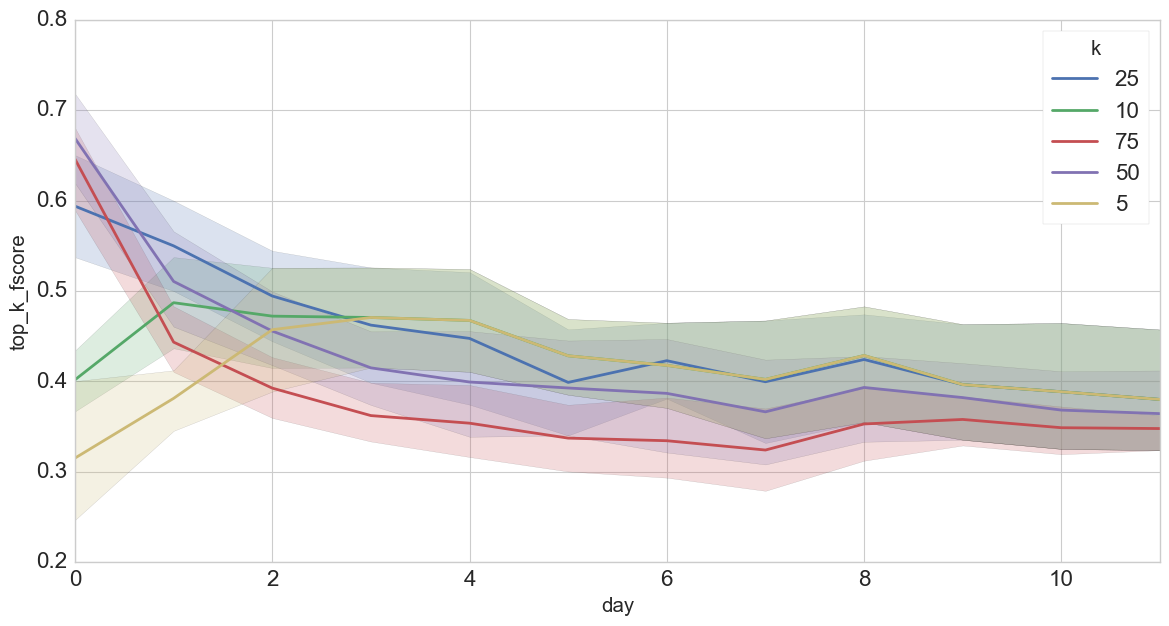

In [109]:
# df = df_full
# df['top_k_fscore'] = fscore(df['top_k_prec'], df['top_k_rec'])
# df = df[df.classifier == 'XGB']
# # df[df.day == 0].sort_values(by='top_k_fscore')
# sns.tsplot(time='day', unit='code_module', condition='k', value='top_k_fscore', data=df, ci=[95])

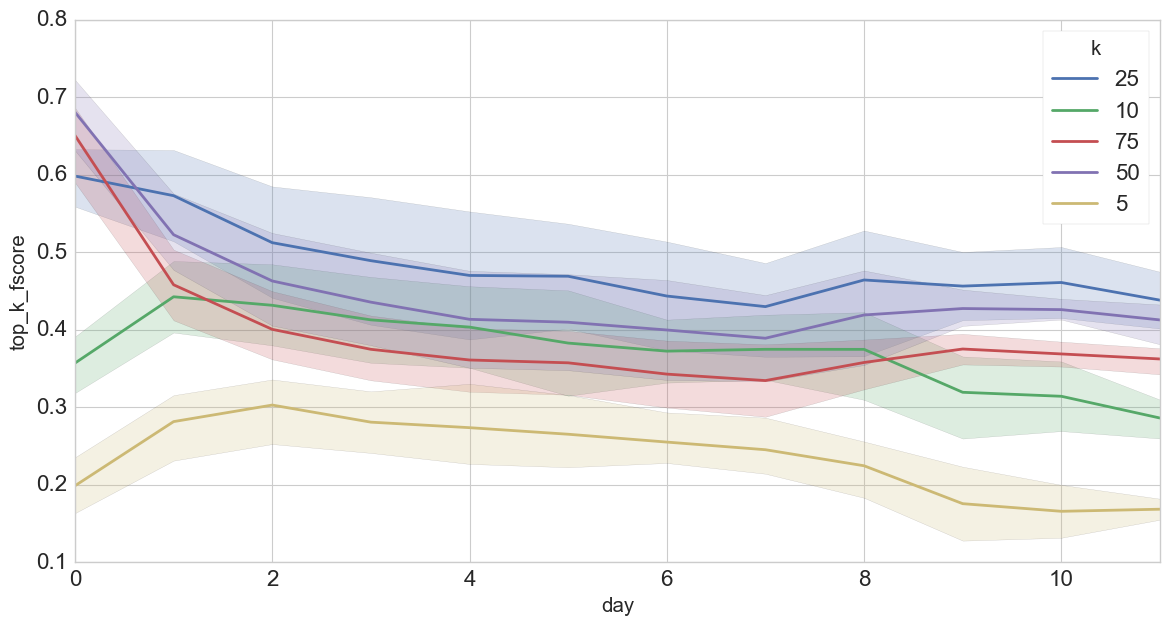

In [120]:
# df = df_full
# df['top_k_fscore'] = fscore(df['top_k_prec'], df['top_k_rec'])
# df = df[df.classifier == 'SVM-W-R']
# # df[df.day == 0].sort_values(by='top_k_fscore')
# sns.tsplot(time='day', unit='code_module', condition='k', value='top_k_fscore', data=df, ci=[95])

### Detailed decomposition to Precision and Recall 

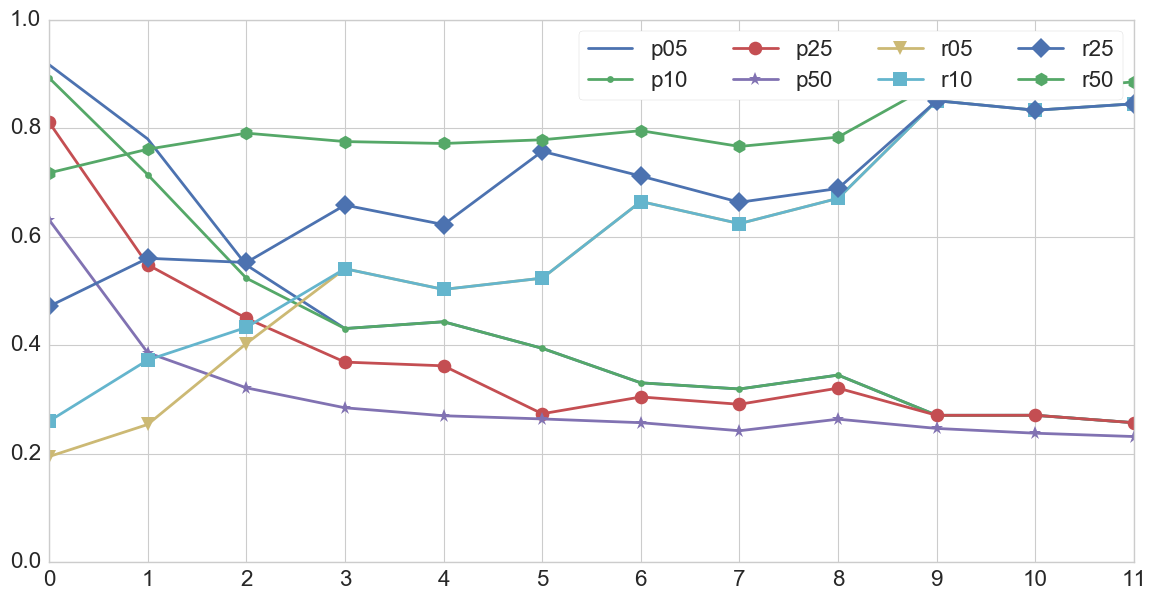

In [60]:
# df = pd.DataFrame({'p05':p5,'p10':p10, 'p25':p25, 'p50':p50,
#                    'r05':r5,'r10':r10, 'r25':r25, 'r50':r50,
#                   })
# plot_df(df)

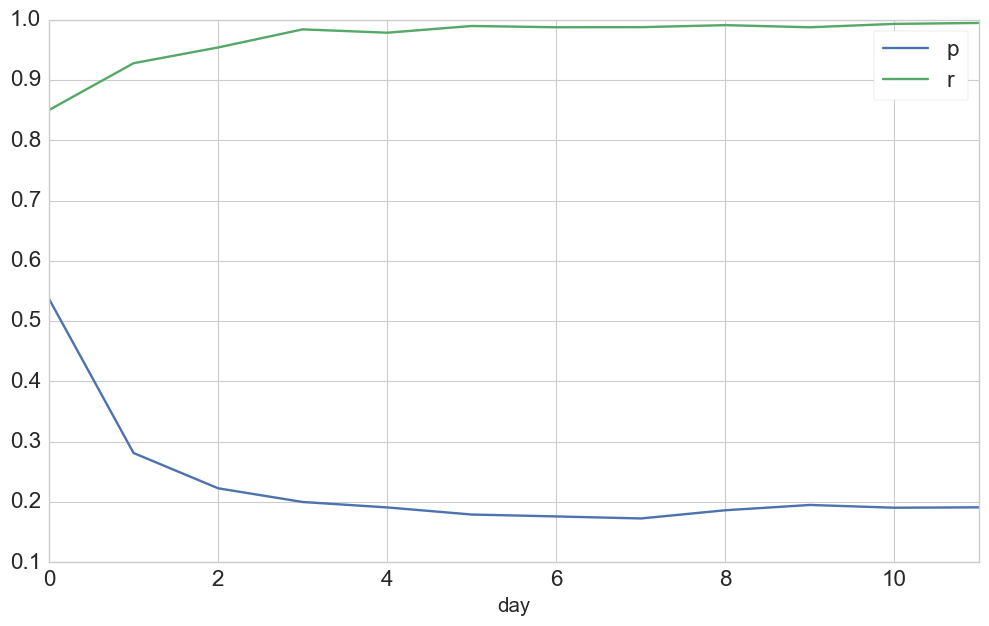

In [58]:
p = dailyExpSelflearner.get_metric_daily_df('prec').XGB
df = pd.DataFrame({'p':p,
                   'r':r,
                  })
df.plot()

### Training using the previous presentation 

In [68]:
kwargs = {'train_mode': TrainingType.PREVIOUS_PRES, 'max_days': max_days,
                  'module_presentations':module_presentations_previous,'assessment_name':assessment,
                  'classifiers':classifiers, 'features':features}
%time dailyExpPrevPres = lazy_load(EXP_PREVIOUS_PRES_DUMP_PATH, compute_experiment, kwargs=kwargs)

CPU times: user 976 ms, sys: 3.12 s, total: 4.09 s
Wall time: 6.21 s


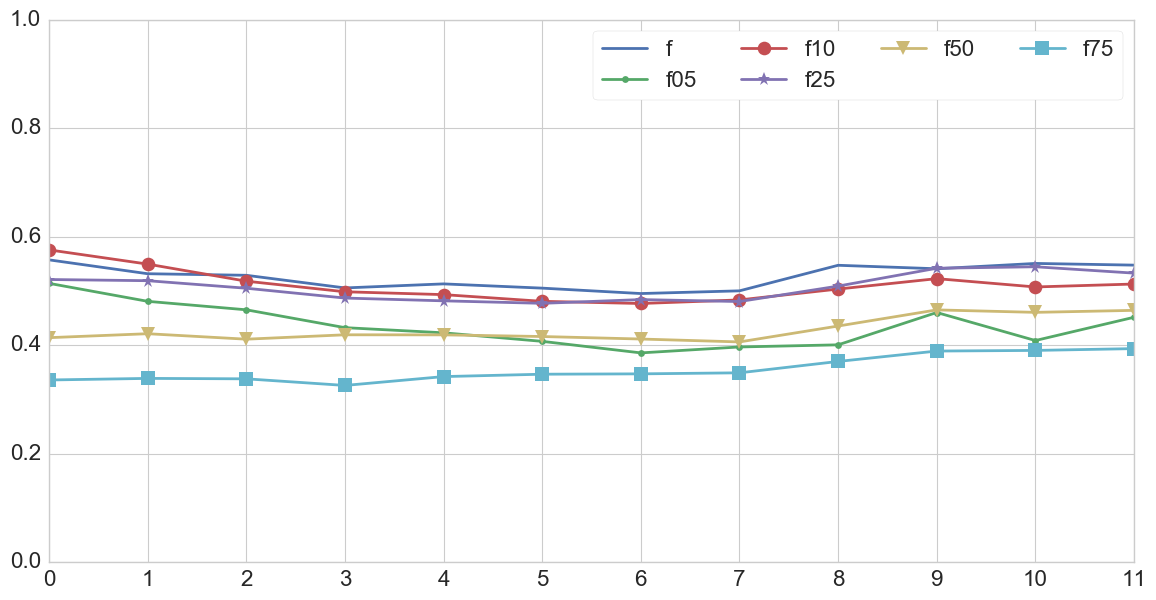

In [70]:
%time df_fscore = get_time_fscore_k_graph(dailyExpSelflearner, 'RF')
plot_df(df_fscore)

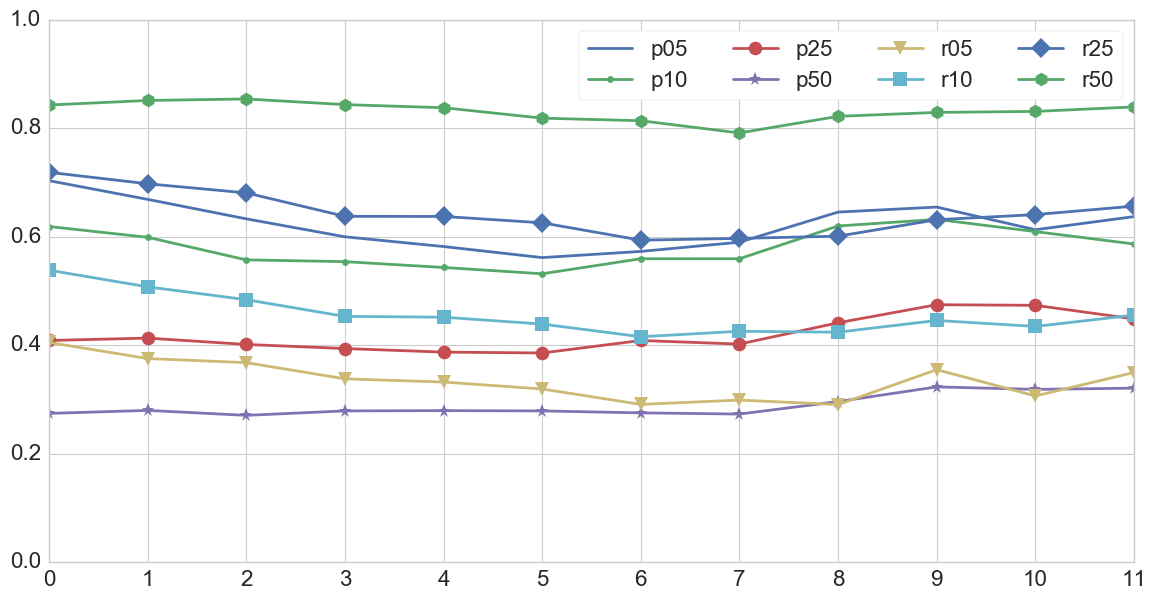

In [71]:
df = pd.DataFrame({'p05':p5,'p10':p10, 'p25':p25, 'p50':p50,
                   'r05':r5,'r10':r10, 'r25':r25, 'r50':r50,
                  })
plot_df(df)

In [ ]:
cl_limit = [
       (SVC(kernel="rbf", gamma='auto', C=1, probability=True, class_weight="balanced"), "SVM-W-R"),
       (LR.LogisticRegression(C=0.01, penalty='l2', class_weight="balanced"), "LR-W"),
       (xgb.XGBClassifier(base_score=0.1, n_estimators=100, max_depth=3, reg_alpha=0.5, reg_lambda=1, learning_rate=0.01 ), "XGB"),
#                (NeverActiveStudentClassifier(), "Base[NotAccessed]"),
#                (DummyClassifier(strategy="constant", constant=1), "Base[NS]")
              ]
EXP_OUROBOROS_DUMP_PATH_2 = os.path.join(SELF_LEARNER_MODULE_PATH, 'exp_ouroboros_2.pkl')





### Feature importance 

In [ ]:
num_of_top_features = 10
classifier  = 'XGB'
res = dailyExpSelflearner.get_top_daily_features(classifier, top=10000)
res_df = pd.DataFrame(res)
top_features = res_df.reset_index().groupby('feature_name')[classifier].max().sort_values().tail(n=num_of_top_features).index.values
res_df_res = res_df.reset_index()
res_df_res = res_df_res[res_df_res.feature_name.isin(top_features)]
res_df_res.set_index(['day','feature_name']).unstack().plot()